In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from sklearn.metrics import roc_curve, auc

from src.analyzer.euroleague_analyzer import EuroLeagueAnalyzer
from src.plotter.euroleague_plotter import EuroLeaguePlotter
from src.predictor.euroleague_predictor import EuroLeaguePredictor

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("EuroLeagueAnalysis").getOrCreate()
# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Read the CSV file into a DataFrame and infer schema
df = spark.read.csv("data/games.csv", header=True, inferSchema=True)

# Extract columns needed for analysis
analysis_columns = ['season', 'team', 'PTS', 'OP_PTS', '3P%', 'OP_3P%', '2P%', 'OP_2P%', 'FTR', 'OP_FTR', 'OREB%', 'DREB%', 'ASTR', 'OP_ASTR', 
                    'TOVR', 'OP_TOVR', 'STLR', 'OP_STLR', 'BLKR', 'OP_BLKR', 'TS%', 'OP_TS%', 'OP_team', 'win']

el_df = df.select(*analysis_columns).withColumn("game_no", (F.monotonically_increasing_id() % df.count()) + 1)

# Show top 5 rows
el_df.show(5)

# create EuroLeaguePlotter object to draw matplotlib graphs
el_plotter = EuroLeaguePlotter()

+------+----+---+------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+-----+-------+
|season|team|PTS|OP_PTS|               3P%|            OP_3P%|              2P%|           OP_2P%|               FTR|            OP_FTR|             OREB%|            DREB%|             ASTR|          OP_ASTR|              TOVR|           OP_TOVR|              STLR|           OP_STLR|              BLKR|           OP_BLKR|               TS%|            OP_TS%|OP_team|  win|game_no|
+------+----+---+------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+----

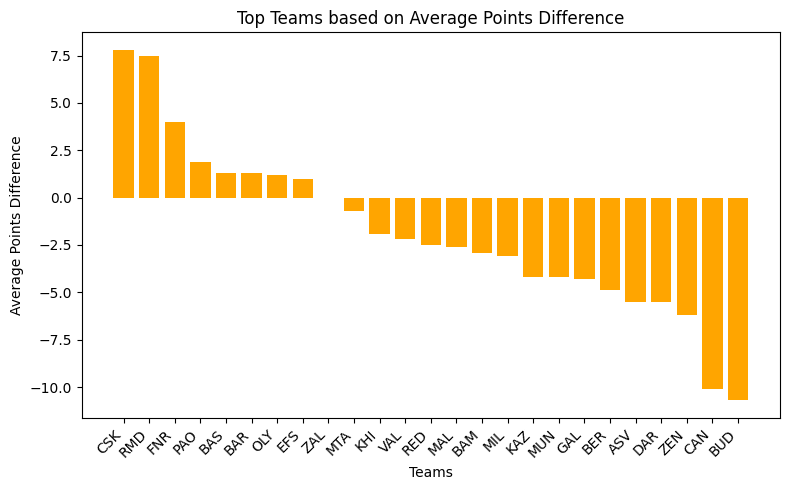

In [3]:
# Create EuroLeagueAnalyzer object to get average OFF and DEF stats
el_analyzer = EuroLeagueAnalyzer(spark, el_df)
avg_df = el_analyzer.calculate_team_averages()

# Convert DataFrame to Pandas DataFrame for plotting
top_teams_pd = avg_df.toPandas()

# Plot averages graph
el_plotter.plot_stats_graph(top_teams_pd, "team", "AVG_PTS_DIFF", "Teams", "Average Points Difference", "Top Teams based on Average Points Difference")

+----+------+-------------+
|team|season|streak_length|
+----+------+-------------+
| RMD|  2019|           13|
| KAZ|  2016|           12|
| FNR|  2018|           12|
| DAR|  2018|           12|
| BUD|  2018|           10|
| MIL|  2016|           10|
| CAN|  2018|           10|
| VAL|  2017|           10|
| RMD|  2016|            9|
| ZAL|  2019|            9|
+----+------+-------------+
only showing top 10 rows



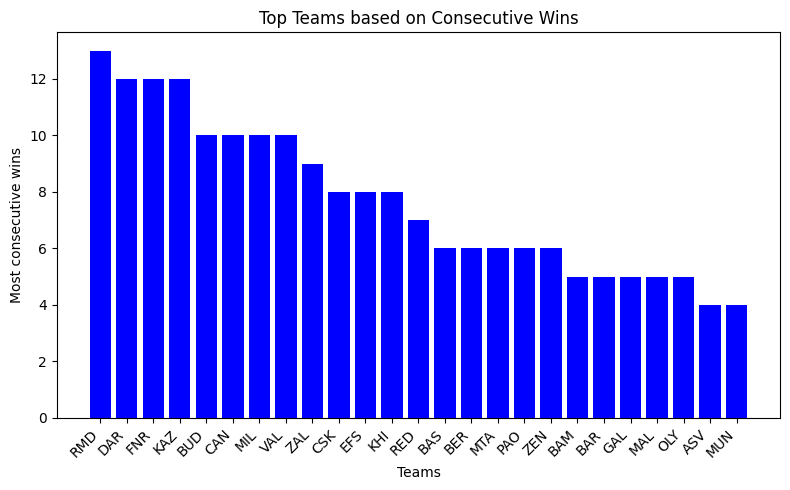

In [4]:
# Get largest win streaks and show top 10
streak_df = el_analyzer.calculate_team_win_streaks()
streak_df.show(10)

top_win_streaks_pd = streak_df.toPandas()

# Plot win streak graph
el_plotter.plot_stats_graph(top_win_streaks_pd, "team", "streak_length", "Teams", "Most consecutive wins", "Top Teams based on Consecutive Wins", "blue")

In [5]:
# Create model for game prediction

# These are feature and label columns for our model - we want to see how game result depends on these stats
feature_columns = ['3P%', 'OP_3P%', '2P%', 'OP_2P%', 'FTR', 'OP_FTR', 'ASTR', 'OP_ASTR', 
                    'TOVR', 'OP_TOVR', 'STLR', 'OP_STLR', 'BLKR', 'OP_BLKR']

label_column = "did_win"

# Add label column with values [0,1] instead of true/false - suited for Logistic Regression
el_df = el_df.withColumn(label_column, F.when(df["win"] == True, 1).otherwise(0)).drop("win")

# Create instance of EuroLeague predictor class and train the model
el_predictor = EuroLeaguePredictor(spark, feature_columns, label_column)
el_predictor.load_data(el_df)

# Preprocess data
el_predictor.preprocess_data()

# Train the model
el_predictor.train_model()

# Evaluate the model - check accuracy
el_predictor.evaluate_model()

Model Accuracy: 0.934750478177708


Area under ROC curve: 0.9347504781777082


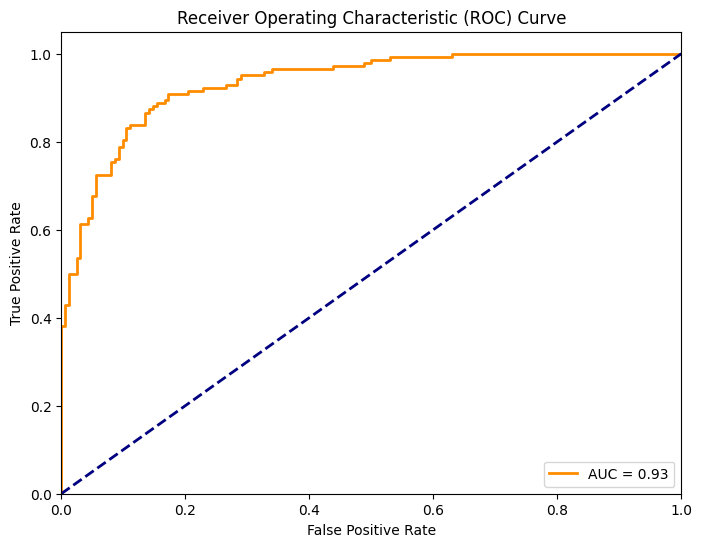

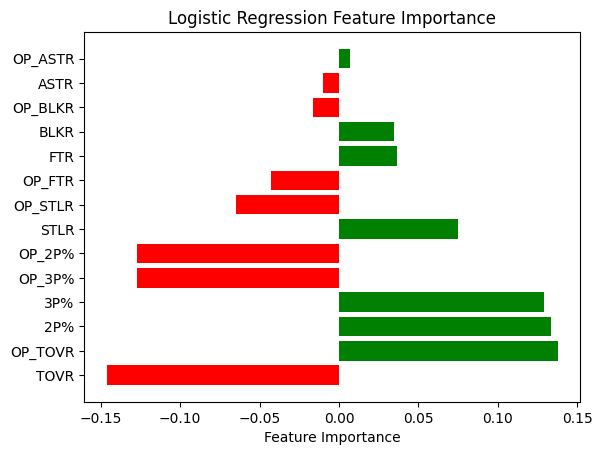

In [6]:
# Get some insights from model using graphs
model = el_predictor.get_model()
test_predictions = el_predictor.get_test_predictions()


# Get the true positive rate and false positive rate for the ROC 
labels = [float(row[label_column]) for row in test_predictions[0]]
probabilities = [float(row.probability[1]) for row in test_predictions[1]]
fpr, tpr, _ = roc_curve(labels, probabilities)
auc_roc = auc(fpr, tpr)

# Plot roc curve
print(f"Area under ROC curve: {auc_roc}")
el_plotter.plot_roc_curve(fpr, tpr, auc_roc)


# Check importance for each feature
feature_importance = model.stages[-1].coefficients
feature_importance_dict = dict(zip(feature_columns, feature_importance))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_feature_names, sorted_importance = zip(*sorted_features)

# Plot graph for feature importance (negative value means positive for opposing team!)
el_plotter.plot_model_feature_graph(sorted_feature_names, sorted_importance)

In [7]:
# Predict outcome for new games
new_data_cols = [item for item in analysis_columns if item not in ["PTS", "OP_PTS", "win"]]

new_games_df = spark.read.csv("data/new_games.csv", header=True, inferSchema=True).select(*new_data_cols)
new_games_df.show()

predictions = el_predictor.predict(new_games_df)
predictions.show()

+------+----+------------------+------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+----------------+-----------------+-----------------+-------+
|season|team|               3P%|OP_3P%|              2P%|            OP_2P%|               FTR|           OP_FTR|             OREB%|            DREB%|             ASTR|           OP_ASTR|             TOVR|           OP_TOVR|             STLR|           OP_STLR|             BLKR|         OP_BLKR|              TS%|           OP_TS%|OP_team|
+------+----+------------------+------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+----------------+-----------------+----

In [8]:
# Stop the Spark session
spark.stop()